# RSNA Pneumonia Localization (Weakly Supervised CAM Approach)

This notebook reproduces the *Weakly Supervised Pneumonia Localization* method from the research paper (our ML assignment).  
It combines:
- A **CNN classifier** to predict pneumonia vs normal.
- A **Class Activation Map (CAM)** to highlight the pneumonia region.
- A **clustering + bounding box** method to localize the infected area.
- Evaluation using **Intersection over Union (IoU)** metric.

We’ll use a **small subset** of the RSNA Pneumonia dataset for fast computation.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1 — Install Dependencies

This installs any required Python libraries like PyTorch, OpenCV, and pydicom (for reading `.dcm` medical images).  
Run this once — skip if already installed.


In [8]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.8 MB/s eta 0:00:00


## Step 2 — Unzip and Explore Dataset

We unzip the RSNA Pneumonia Detection dataset from Google Drive and inspect its structure.  
The dataset contains:
- **stage_2_train_images/** → chest X-ray images in DICOM format.
- **stage_2_train_labels.csv** → bounding box coordinates and labels.


In [9]:
import os
import zipfile
from pathlib import Path

ZIP_PATH = "/content/drive/MyDrive/ML ASSIGNMENT/rsna-pneumonia-detection-challenge (1).zip"
EXTRACT_TO = "/content/rsna_data"

print("Zip path:", ZIP_PATH)
if not os.path.exists(EXTRACT_TO):
    print("Unzipping dataset (this may take ~30s)...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(EXTRACT_TO)
else:
    print("Already unzipped at", EXTRACT_TO)

# show top-level files
for root, dirs, files in os.walk(EXTRACT_TO):
    print("Top contents example ->", root)
    print("  # dirs:", len(dirs), " # files:", len(files))
    break

# print important expected paths
expected_csv = os.path.join(EXTRACT_TO, "stage_2_train_labels.csv")
img_dir = os.path.join(EXTRACT_TO, "stage_2_train_images")
print("Expected CSV:", expected_csv)
print("Image dir:", img_dir)


Zip path: /content/drive/MyDrive/ML ASSIGNMENT/rsna-pneumonia-detection-challenge (1).zip
Unzipping dataset (this may take ~30s)...
Top contents example -> /content/rsna_data
  # dirs: 2  # files: 4
Expected CSV: /content/rsna_data/stage_2_train_labels.csv
Image dir: /content/rsna_data/stage_2_train_images


## Step 3 — Import Libraries

Here we import all essential libraries for:
- Image processing (`cv2`, `pydicom`, `numpy`)
- Data handling (`pandas`)
- Deep learning (`torch`, `torchvision`)
- Visualization (`matplotlib`)


In [10]:
import pydicom
import numpy as np
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

print("Imports done.")


Imports done.


## Step 4 — Load and Explore CSV Labels

We load the CSV file containing pneumonia annotations:
- Each image (patientId) can have 0 or more bounding boxes.
- `Target = 1` means pneumonia is present (box provided).
- `Target = 0` means no pneumonia (no bounding box).

We also group by patient ID to easily retrieve annotations later.


In [11]:
CSV_PATH = os.path.join(EXTRACT_TO, "stage_2_train_labels.csv")
df = pd.read_csv(CSV_PATH)
print("CSV rows:", len(df))
print(df.head())

# CSV columns: patientId, x, y, width, height, Target
# Target = 1 means pneumonia box present; 0 typically indicates no box (image-level negative)
# group boxes by patientId for easy lookup
grouped = df.groupby("patientId")
print("Unique patient IDs:", df['patientId'].nunique())


CSV rows: 30227
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
Unique patient IDs: 26684


## Step 5 — DICOM to Image Conversion

This function:
- Reads `.dcm` medical images.
- Normalizes pixel values (0–255 range).
- Converts grayscale to RGB.
- Resizes to `128×128` for faster training.

We also test one sample image to confirm it works.


Example path exists: True
Image shape: (128, 128, 3)


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

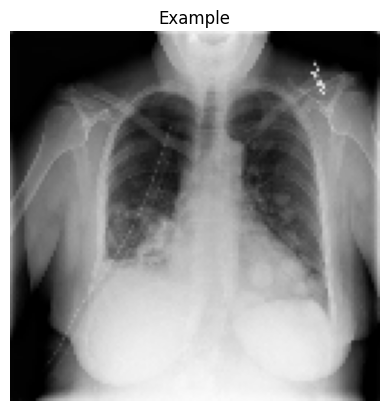

In [12]:
def read_dicom_as_image(path, target_size=(128,128)):
    ds = pydicom.dcmread(path)
    arr = ds.pixel_array.astype(np.float32)
    # normalize to 0-255
    arr -= arr.min()
    if arr.max() > 0:
        arr = arr / arr.max()
    arr = (arr * 255).astype(np.uint8)
    # convert to 3-channel
    img = cv2.cvtColor(arr, cv2.COLOR_GRAY2BGR)
    img = cv2.resize(img, target_size)
    return img

# quick test
example_imgname = df['patientId'].iloc[0]
example_path = os.path.join(EXTRACT_TO, "stage_2_train_images", example_imgname + ".dcm")
print("Example path exists:", os.path.exists(example_path))
img = read_dicom_as_image(example_path)
print("Image shape:", img.shape)
plt.imshow(img, cmap='gray'); plt.title("Example"); plt.axis('off')


## Step 6 — Custom Dataset Class

This dataset class handles:
- Loading image tensors.
- Assigning pneumonia labels (`1` = positive, `0` = negative).
- Scaling bounding boxes to match the resized 128×128 images.

It also returns ground truth boxes for IoU comparison later.


In [13]:
import pydicom
import numpy as np
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class RSNADataset(Dataset):
    def __init__(self, csv_df, images_dir, ids_list, transform=None):
        self.df = csv_df
        self.images_dir = images_dir
        self.ids = ids_list
        self.transform = transform

        # mapping id -> list of boxes
        self.boxes = {}
        for pid, group in self.df.groupby("patientId"):
            boxes = []
            for _, r in group.iterrows():
                if r['Target'] == 1:
                    x, y, w, h = r['x'], r['y'], r['width'], r['height']
                    boxes.append([x, y, w, h])
            if len(boxes) > 0:
                self.boxes[pid] = boxes

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        pid = self.ids[idx]
        dcm_path = os.path.join(self.images_dir, pid + ".dcm")
        img = read_dicom_as_image(dcm_path, target_size=(128,128))

        # label: 1 if has pneumonia annotation in CSV, else 0
        label = 1 if pid in self.boxes else 0

        # normalized float32 tensor (C,H,W) for PyTorch
        img_float = img.astype(np.float32) / 255.0
        img_t = torch.tensor(img_float).permute(2,0,1).float()

        # --- FIX STARTS HERE ---
        if pid in self.boxes:
            # original boxes were in original DICOM pixel coords; we need to scale them to 128x128
            ds = pydicom.dcmread(dcm_path)
            orig_h, orig_w = ds.pixel_array.shape
            hx, hy = 128.0 / orig_w, 128.0 / orig_h
            gt_boxes_resized = []
            for (x, y, w, h) in self.boxes[pid]:
                x1 = int(x * hx); y1 = int(y * hy)
                x2 = int((x + w) * hx); y2 = int((y + h) * hy)
                gt_boxes_resized.append([x1, y1, x2, y2])
        else:
            gt_boxes_resized = []   # ✅ FIX: empty list instead of None
        # --- FIX ENDS HERE ---

        return img_t, label, pid, gt_boxes_resized

def custom_collate_fn(batch):
    """
    Custom collate function to handle different number of bounding boxes
    and potential None values for ground truth boxes.
    """
    imgs = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    pids = [item[2] for item in batch]
    gt_boxes_resized = [item[3] for item in batch]  # now always a list, never None

    return imgs, labels, pids, gt_boxes_resized

print("✅ Dataset class fixed and ready. Empty lists used instead of None.")


✅ Dataset class fixed and ready. Empty lists used instead of None.


## Step 7 — Create Subset and DataLoaders

We use only a **small subset** of the dataset (e.g., 80 images) for quick runs.  
Images are split into **training** and **validation** sets.

`DataLoader` helps batch and shuffle data efficiently during training.


In [14]:
# SETTINGS: small subset for speed
SUBSET_SIZE = 10000   # total images to use (you can reduce to 40 if very slow)
VAL_FRACTION = 0.2
random.seed(42)

all_ids = df['patientId'].unique().tolist()
print("Total images available:", len(all_ids))

# sample a subset
subset_ids = random.sample(all_ids, SUBSET_SIZE)
train_ids, val_ids = train_test_split(subset_ids, test_size=VAL_FRACTION, random_state=42)

train_ds = RSNADataset(df, os.path.join(EXTRACT_TO, "stage_2_train_images"), train_ids)
val_ds   = RSNADataset(df, os.path.join(EXTRACT_TO, "stage_2_train_images"), val_ids)

print("Train size:", len(train_ds), "Val size:", len(val_ds))
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=custom_collate_fn)

Total images available: 26684
Train size: 8000 Val size: 2000


## Step 8 — Build CNN Model (CAM-Compatible)

This is a lightweight CNN architecture similar to the paper’s 10-layer design but smaller for speed.  
It ends with:
- A **Global Average Pooling (GAP)** layer.
- A **Fully Connected (FC)** layer with 2 outputs (Pneumonia / Normal).

This structure allows **Class Activation Maps (CAMs)** to be extracted later.


In [15]:
class SmallCAMNet(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        # feature extractor (final conv outputs channels = 64)
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
            # final conv output: (batch,64,32,32) given 128x128 input after two pools
        )
        # global average pool -> fc
        self.gap = nn.AdaptiveAvgPool2d(1)  # produces (batch,64,1,1)
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        feat = self.features(x)
        gap = self.gap(feat).view(feat.size(0), -1)
        out = self.fc(gap)
        return out, feat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCAMNet(n_classes=2).to(device)
print("Model created on", device)


Model created on cpu


## Step 9 — Train the Model (Quick Training)

We train for only a few epochs on the subset using:
- **Adam optimizer**
- **CrossEntropyLoss**

This is enough to demonstrate classification and generate meaningful CAMs.  
Print statements show batch-wise progress and accuracy updates.


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 5   # small so it runs quickly; increase if you have time
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total = 0; correct = 0
    for i, (imgs, labels, pids, _) in enumerate(train_loader):
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0); correct += (preds == labels).sum().item()
        if i % 5 == 0:
            print(f"Epoch {epoch+1} batch {i} loss {loss.item():.4f} acc {correct/total:.3f}")
    print(f"Epoch {epoch+1} completed. Avg loss: {running_loss/(i+1):.4f}, Train acc: {correct/total:.3f}")
    # quick validation
    model.eval()
    v_total=0; v_correct=0
    with torch.no_grad():
        for imgs, labels, pids, _ in val_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            outputs, _ = model(imgs)
            _, preds = torch.max(outputs, 1)
            v_total += labels.size(0); v_correct += (preds == labels).sum().item()
    print(f"Validation acc after epoch {epoch+1}: {v_correct/v_total:.3f}")
print("Training done.")


Epoch 1 batch 0 loss 0.6769 acc 0.625
Epoch 1 batch 5 loss 0.7475 acc 0.292
Epoch 1 batch 10 loss 0.7278 acc 0.307
Epoch 1 batch 15 loss 0.6983 acc 0.281
Epoch 1 batch 20 loss 0.6576 acc 0.387
Epoch 1 batch 25 loss 0.7202 acc 0.471
Epoch 1 batch 30 loss 0.5747 acc 0.524
Epoch 1 batch 35 loss 0.6749 acc 0.542
Epoch 1 batch 40 loss 0.4990 acc 0.564
Epoch 1 batch 45 loss 0.5457 acc 0.587
Epoch 1 batch 50 loss 0.7171 acc 0.608
Epoch 1 batch 55 loss 0.2430 acc 0.632
Epoch 1 batch 60 loss 0.6171 acc 0.639
Epoch 1 batch 65 loss 0.3532 acc 0.661
Epoch 1 batch 70 loss 0.7516 acc 0.669
Epoch 1 batch 75 loss 0.9813 acc 0.669
Epoch 1 batch 80 loss 0.3607 acc 0.676
Epoch 1 batch 85 loss 0.7043 acc 0.683
Epoch 1 batch 90 loss 0.2794 acc 0.688
Epoch 1 batch 95 loss 0.8282 acc 0.690
Epoch 1 batch 100 loss 0.5335 acc 0.699
Epoch 1 batch 105 loss 0.4439 acc 0.698
Epoch 1 batch 110 loss 0.8574 acc 0.699
Epoch 1 batch 115 loss 0.4469 acc 0.707
Epoch 1 batch 120 loss 0.4404 acc 0.706
Epoch 1 batch 125 loss

## Step 10 — Generate Class Activation Maps (CAM)

The CAM highlights which areas of the X-ray image influenced the “Pneumonia” prediction.  
We:
1. Extract the last convolutional layer features.
2. Weight them using the FC layer’s pneumonia class weights.
3. Combine and normalize them into a heatmap.

Higher intensity = higher pneumonia probability region.


In [17]:
def generate_cam_for_tensor(model, input_tensor, class_idx=1):
    """
    input_tensor: 1 x C x H x W (torch tensor on device)
    class_idx: target class index (1 = pneumonia for our labeling)
    returns: cam_resized (H,W) normalized 0-1
    """
    model.eval()
    with torch.no_grad():
        outputs, features = model(input_tensor)
        # get fc weights (shape: n_classes x n_features)
        fc_w = model.fc.weight.data.cpu().numpy()  # shape (2,64)
        # features shape: 1 x C x h x w
        feat = features[0].cpu().numpy()  # (C, h, w)
        cams = np.zeros((feat.shape[1], feat.shape[2]), dtype=np.float32)
        # compute weighted sum of feature maps
        for k in range(feat.shape[0]):
            cams += fc_w[class_idx, k] * feat[k, :, :]
        # relu
        cams = np.maximum(cams, 0)
        # normalize
        if cams.max() > 0:
            cams = cams / (cams.max() + 1e-8)
        # resize to input size
        _, _, H, W = input_tensor.shape
        cam_resized = cv2.resize(cams, (W, H))
        return cam_resized

print("CAM function ready.")


CAM function ready.


## Step 11 — CAM to Bounding Boxes (DFS-like Clustering)

We convert the CAM into regions by:
- Thresholding (using `mean + std/2` as a cutoff).
- Grouping connected bright regions (like DFS clustering).
- Drawing bounding boxes around each region.

These boxes represent **predicted pneumonia locations**.


In [18]:
def cam_to_bboxes(cam, threshold=None, min_area=50):
    """
    cam: 2D normalized 0-1
    threshold: if None, use mean + std heuristic
    returns: list of bounding boxes [x1,y1,x2,y2] in cam coordinates (same size)
    """
    if threshold is None:
        threshold = cam.mean() + cam.std()*0.5
    mask = (cam > threshold).astype(np.uint8)
    # morphological closing to join small holes
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    num_labels, labels_im = cv2.connectedComponents(mask)
    bboxes = []
    for lbl in range(1, num_labels):
        ys, xs = np.where(labels_im == lbl)
        if len(xs) == 0:
            continue
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()
        area = (x2-x1)*(y2-y1)
        if area >= min_area:
            bboxes.append([int(x1), int(y1), int(x2), int(y2)])
    return bboxes

print("Bbox extraction ready.")


Bbox extraction ready.


## Step 12 — IoU (Intersection over Union) Function

The IoU measures how much the **predicted** bounding box overlaps with the **ground truth**.  
\[
IoU = \frac{Area\ of\ Overlap}{Area\ of\ Union}
\]

A higher IoU means better localization accuracy.


In [19]:
def iou_box(boxA, boxB):
    """
    box = [x1,y1,x2,y2]
    returns IoU float
    """
    if boxA is None or boxB is None:
        return 0.0
    ax1, ay1, ax2, ay2 = boxA
    bx1, by1, bx2, by2 = boxB
    inter_x1 = max(ax1, bx1); inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2); inter_y2 = min(ay2, by2)
    iw = max(0, inter_x2 - inter_x1 + 1)
    ih = max(0, inter_y2 - inter_y1 + 1)
    inter_area = iw * ih
    areaA = (ax2 - ax1 + 1) * (ay2 - ay1 + 1)
    areaB = (bx2 - bx1 + 1) * (by2 - by1 + 1)
    denom = areaA + areaB - inter_area
    if denom <= 0:
        return 0.0
    return inter_area / float(denom)

print("IoU function ready.")


IoU function ready.


## Step 13 — Evaluate Model and Visualize Results

For each validation image:
- Generate the CAM.
- Extract bounding boxes.
- Compare with ground truth boxes using IoU.

We print:
- CAM statistics (mean, std, threshold used)
- Predicted vs ground truth boxes
- IoU scores

We also visualize sample images with:
- **Red boxes = Ground Truth**
- **Blue boxes = Predicted (CAM regions)**
- **Color overlay = Heatmap**


Evaluating on validation set (subset) ...

Processing PID 646917f3-2303-43ef-acac-37470021e91f | label = 1
  CAM min/max/mean/std: 0.0 0.99814755 0.18797518 0.29838285
  Using threshold: 0.3371666
  Predicted boxes (count): 4 [[108, 12, 123, 26], [13, 39, 22, 54], [32, 57, 103, 127], [112, 77, 120, 86]]
  Best IoU for this image: 0.021243723445345693


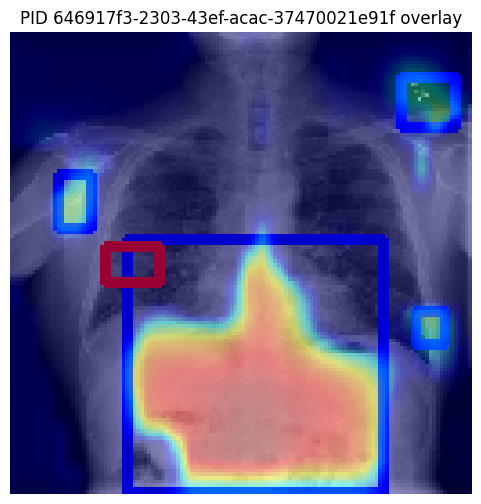


Processing PID 943b27f1-ba1c-415b-b738-7b52aefa445b | label = 0
  CAM min/max/mean/std: 0.0 0.9991468 0.27288234 0.3353652
  Using threshold: 0.44056493
  Predicted boxes (count): 3 [[17, 6, 102, 125], [92, 13, 110, 32], [13, 18, 27, 41]]
  Best IoU for this image: 0.0


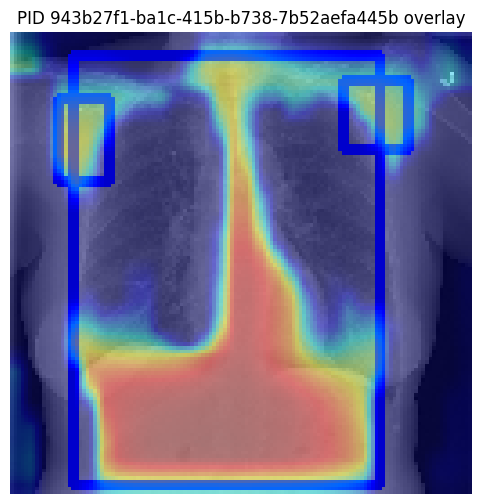


Processing PID 42bfb1f3-9f7e-4e47-8983-49b16d73697f | label = 0
  CAM min/max/mean/std: 0.0 0.9987112 0.1773633 0.2624621
  Using threshold: 0.30859435
  Predicted boxes (count): 6 [[93, 6, 108, 22], [12, 27, 21, 46], [102, 32, 113, 64], [24, 60, 103, 127], [121, 69, 127, 75], [7, 88, 14, 94]]
  Best IoU for this image: 0.0


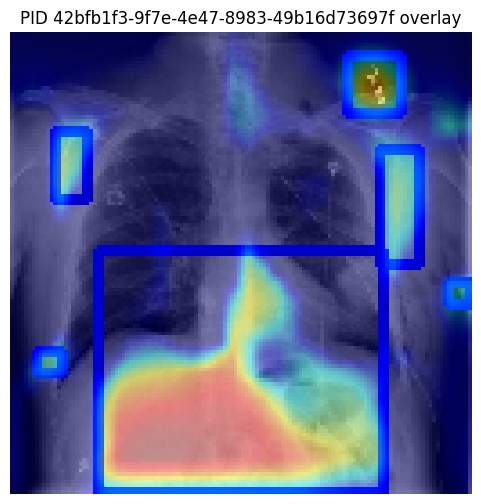


Processing PID 6c14d1da-5519-4205-a97a-79950670c257 | label = 0
  CAM min/max/mean/std: 0.0 0.9988912 0.16170141 0.27752686
  Using threshold: 0.30046484
  Predicted boxes (count): 5 [[106, 4, 127, 20], [12, 29, 19, 57], [81, 34, 91, 47], [24, 60, 107, 127], [115, 94, 123, 104]]
  Best IoU for this image: 0.0


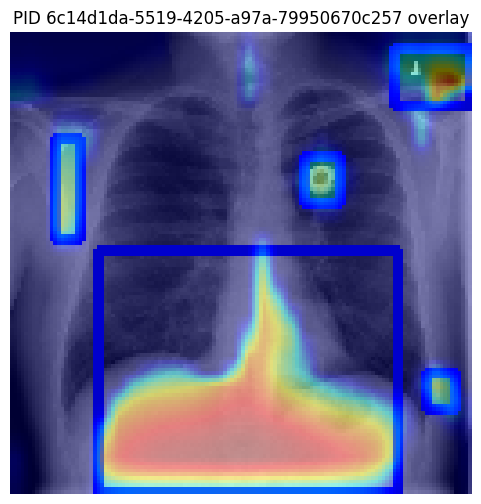


Processing PID 05083068-f4df-464a-b669-3c084ee05f1f | label = 1
  CAM min/max/mean/std: 0.0 0.9989945 0.210789 0.32044128
  Using threshold: 0.37100965
  Predicted boxes (count): 3 [[108, 3, 127, 36], [25, 22, 29, 29], [28, 49, 90, 127]]
  Best IoU for this image: 0.024489795918367346


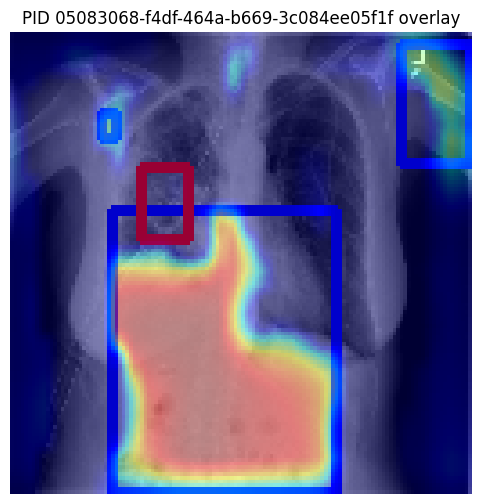


Processing PID dd48746a-162b-41da-8248-8adcaaa87080 | label = 0
  CAM min/max/mean/std: 0.0 0.9987934 0.19355246 0.30967534
  Using threshold: 0.34839013
  Predicted boxes (count): 2 [[19, 55, 94, 127], [113, 54, 127, 72]]
  Best IoU for this image: 0.0


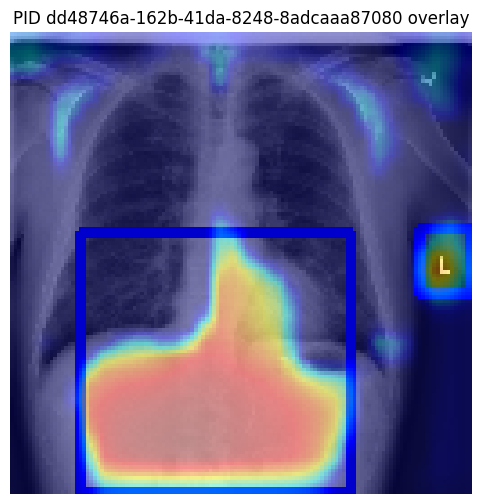

Streaming output truncated to the last 5000 lines.

Processing PID bed364d9-7bad-4de8-b618-9de875b73d67 | label = 1
  CAM min/max/mean/std: 0.0 0.9992822 0.30655593 0.3564948
  Using threshold: 0.48480332
  Predicted boxes (count): 3 [[13, 12, 29, 48], [93, 12, 114, 74], [17, 47, 100, 124]]
  Best IoU for this image: 0.17751479289940827

Processing PID 2875f1b1-25d0-455a-b098-728ae2ee84ce | label = 0
  CAM min/max/mean/std: 0.0 0.9702768 0.21581987 0.22745772
  Using threshold: 0.32954872
  Predicted boxes (count): 4 [[28, 38, 90, 125], [5, 48, 18, 94], [92, 59, 111, 92], [4, 115, 11, 124]]
  Best IoU for this image: 0.0

Processing PID e678a93a-0519-420a-9b4b-4f9ae4e0a006 | label = 1
  CAM min/max/mean/std: 0.0 0.9929433 0.26860562 0.2670692
  Using threshold: 0.4021402
  Predicted boxes (count): 5 [[0, 0, 21, 17], [105, 0, 127, 29], [34, 11, 46, 23], [12, 63, 82, 124], [98, 75, 127, 127]]
  Best IoU for this image: 0.08181413961760782

Processing PID fc4d3a9c-ca9e-400f-a849-2513379b3

In [20]:
print("Evaluating on validation set (subset) ...")
# Check if model is defined
if 'model' not in locals() and 'model' not in globals():
    raise NameError("Model is not defined. Please run the cell 'Step 8 — Build CNN Model (CAM-Compatible)' first.")

model.eval()

all_ious = []
count = 0
pid_list = []  # <-- new: to store PIDs for table
with torch.no_grad():
    for imgs, labels, pids, gt_boxes in val_loader:
        for b in range(imgs.size(0)):
            img = imgs[b].unsqueeze(0).to(device)
            label = int(labels[b].item())
            pid = pids[b]
            print(f"\nProcessing PID {pid} | label = {label}")
            cam = generate_cam_for_tensor(model, img, class_idx=1)
            print("  CAM min/max/mean/std:", cam.min(), cam.max(), cam.mean(), cam.std())
            # adaptive thresholding
            threshold = cam.mean() + cam.std()*0.5
            print("  Using threshold:", threshold)
            bboxes = cam_to_bboxes(cam, threshold=threshold, min_area=25)
            print("  Predicted boxes (count):", len(bboxes), bboxes)
            # get ground truth box (if any)
            gt_list = gt_boxes[b]  # this is the resized gt boxes list or None
            if gt_list is None:
                print("  No ground truth box for this image (negative). Skipping IoU -> append 0.")
                all_ious.append(0.0)
                pid_list.append((pid, 0.0))
            else:
                # if multiple GT boxes, compare to each predicted box and take max IoU
                best_iou_for_image = 0.0
                for gt in gt_list:
                    for pred in bboxes:
                        iou_val = iou_box(pred, gt)
                        if iou_val > best_iou_for_image:
                            best_iou_for_image = iou_val
                print("  Best IoU for this image:", best_iou_for_image)
                all_ious.append(best_iou_for_image)
                pid_list.append((pid, best_iou_for_image))
            # show visualization for first few images
            if count < 6:
                import matplotlib.pyplot as plt
                npimg = (img[0].cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
                vis = npimg.copy()
                # draw predicted boxes in blue
                for pb in bboxes:
                    cv2.rectangle(vis, (pb[0], pb[1]), (pb[2], pb[3]), (255,0,0), 2)
                # draw GT boxes in red
                if gt_list is not None:
                    for gt in gt_list:
                        cv2.rectangle(vis, (gt[0], gt[1]), (gt[2], gt[3]), (0,0,255), 2)
                # overlay heatmap
                heatmap = (cam * 255).astype(np.uint8)
                heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
                heatmap = cv2.resize(heatmap, (vis.shape[1], vis.shape[0]))
                overlay = cv2.addWeighted(vis, 0.6, heatmap, 0.4, 0)
                plt.figure(figsize=(6,6)); plt.imshow(overlay[:,:,::-1]); plt.title(f"PID {pid} overlay"); plt.axis('off')
                plt.show()
            count += 1

import numpy as np
mean_iou = float(np.mean(all_ious))
print("\n=== Results ===")
print("Evaluated images:", len(all_ious))
print("Mean IoU (subset):", mean_iou)
print("IoU list (first 20):", all_ious[:20])

# ---------- NEW: Neat Table Print ----------
print("\n=== Detailed IoU Table ===")
print(f"{'Index':<6} {'PID':<40} {'IoU':>8}")
print("-"*58)
for idx, (pid, iou_val) in enumerate(pid_list):
    print(f"{idx+1:<6} {pid:<40} {iou_val:>8.4f}")
print("-"*58)
print(f"{'Mean IoU':<46} {mean_iou:>8.4f}")
print("===========================================")

## Step 14 — Check Raw Classifier Predictions

This prints the **softmax probabilities** for a few validation images.  
If all predictions are near `[1, 0]`, the model thinks every image is “Normal”.  
That means you need more training epochs or more positive examples.


In [21]:
# Quick check of raw classifier outputs on validation set
model.eval()
with torch.no_grad():
    for imgs, labels, pids, _ in val_loader:
        imgs = imgs.to(device)
        outputs, _ = model(imgs)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        print("Outputs (first batch):", probs[:5])
        break


Outputs (first batch): [[0.82344896 0.17655101]
 [0.7130007  0.28699932]
 [0.8324051  0.16759492]
 [0.96363884 0.03636116]
 [0.86087334 0.1391267 ]]
